<a href="https://colab.research.google.com/github/alexlaurence/CLARA/blob/master/CLARA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installation

In [0]:
!pip install opencv-python
!pip install tensorflow
!pip install progressbar

  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built progressbar


In [0]:
#progress bar
import progressbar
from time import sleep

# for deep learning
import tensorflow as tf

# for extracting zip files
import zipfile

# for uploading files
from google.colab import files

# for i/o stuf
import os
import sys
import getopt
import nibabel as nib
import numpy
import scipy
import shutil

# plotting data
import matplotlib.pylab as plt
from matplotlib import pyplot as plt
import pandas as pd

# training the model
from sklearn.utils import shuffle
import dataset
from datetime import timedelta
import math
import random
from numpy.random import seed
from tensorflow import set_random_seed

# testing the model
import numpy as np
import os,glob,cv2
import sys,argparse
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython import display
import time
from os import listdir
from os.path import isfile, join

# Image manipulation
from matplotlib.pyplot import imshow
import nibabel
import PIL.Image
from PIL import Image 
from IPython.display import display

Let's begin by uploading our data.zip file and unzipping it and getting rid of those annoying thumb files.

In [0]:
print("Extracting...")
train_zip = zipfile.ZipFile('/content/training_data.zip', 'r')
train_zip.extractall()
train_zip.close()
print("Extracted!")

shutil.rmtree('/content/__MACOSX')
print("Deleted /__MACOSX/ resource fork!")

directory = '/content/training_data'
before = len(os.listdir(directory)) 

for root, dirs, files in os.walk(directory):
    i = 0
    for file in files:
        if file.endswith('.DS_Store'):
            path = os.path.join(root, file)

            print("Deleting: %s" % (path))

            if os.remove(path):
                print("Unable to delete!")
            else:
                print("Deleting thumb files...")
        i += 1

after = before - len(os.listdir(directory))        
print("Removed {} DS_Store File(s)".format(after))

Extracting...
Extracted!
/__MACOSX/ folder Deleted
Deleting: /content/training_data/.DS_Store
Deleted!
Removed 1 DS_Store File(s)


In [0]:
print("Extracting...")
test_zip = zipfile.ZipFile('/content/testing_data.zip', 'r')
test_zip.extractall()
test_zip.close()
print("Extracted!")

shutil.rmtree('/content/__MACOSX')
print("Deleted /__MACOSX/ resource fork!")

directory = '/content/testing_data'
before = len(os.listdir(directory)) 

for root, dirs, files in os.walk('/content/testing_data'):
    i = 0
    for file in files:
        if file.endswith('.DS_Store'):
            path = os.path.join(root, file)

            print("Searching: %s" % (path))

            if os.remove(path):
                print("Unable to delete!")
            else:
                print("Deleting thumb files...")
        i += 1

after = before - len(os.listdir(directory))        
print("Removed {} DS_Store File(s)".format(after))


Extracting...
Extracted!
Deleted /__MACOSX/ resource fork!
Searching: /content/testing_data/.DS_Store
Deleting thumb files...
Removed 1 DS_Store File(s)


# CLARA (2019.2.5-beta)

*Convolutional Learning for Awake Rodent-MRI Analysis*

[www.celestial.tokyo/~AlexLaurence/](http://www.celestial.tokyo/~AlexLaurence/)



![alt text](https://i.imgur.com/vPqlnRt.png)

CLARA is an AI-driven tool for predicting noise in awake-rodent fMRI for data-cleaning pipelines in preclinical research.

* CLARA developed by [Alexander Laurence](mailto:alexander.adamlaurence@gmail.com) with the help of various open source tools (TensorFlow, OpenCV).

* RatNet developed by [Alexander Laurence](mailto:alexander.adamlaurence@gmail.com), trained on n=24 male Sprague Dawley® Rats fMRI images (~30,000 images in total). 

**Please note: Unfortunately I cannot distribute the actual training data, or any raw MRI files associated with it. However, you are free to use the pretrained model that I have created from my own work. **

## 1. Introduction

### Relevance
Rodent MRI is a powerful model for preclinical research exploring physiology, pathology and drug development. Particularly, awake rodent functional MRI can allow us to assess concious changes in brain activity across different mental states. However, without anaesthesia, head movement and long interscan intervals can contribute to occasional signal dropout. As such, this can lead to image quality inconsistency as shown in the reduction of grey value intensity. By detecting the images with reduced intensity (i.e. dark images), we aim to repair potential dropouts that may confound the blood oxygen level dependent signals. The goal of this tool is to develop an objective method of defining and detecting signal dropout as dark slices in the effort to repair affected volumes. 

### Training Data
We (Wang Lab, Centre for Clinical Brain Sciences, Edinburgh, UK) scanned the brains of two groups of healthy male adult rats (n=24). The functional images were acquired by a 7-T scanner using a Fast Spin Echo sequence of a 64x64 matrix, TR=2500ms, ETL 16, and effective TE=36ms. 

### Labelling
Two experimenters visually inspected signal dropout at the coronal slices which could also be seen as dark bands in the axial and sagittal views. To provide an objective measurement, mean image intensity was calculated by using ImageJ. Subjective inspection from two experimenters shows highly consistent identification of dark images. Using the image intensity data, we plotted the distribution and established a threshold of detecting the dark images. We defined a threshold that best matching the subjective inspection and formed objective criteria that could be applied across datasets. The resulting agreement left two labels for the images 'good' and 'bad', which we can be have full confidence in by virtue of both subject and objective measures.

In [0]:
labels_raw = pd.read_csv("/content/sample_label.csv.zip", compression='zip', header=0, sep=',', quotechar='"')
labels_raw.sample(5)

,Animal,Slice,Volume,Label
1,280,1,7,bad
6,279,12,3,bad
2,280,4,9,bad
14,279,9,1,good
4,279,13,31,bad


Here's a visual sample of what was labelled as 'bad':

Bad Images


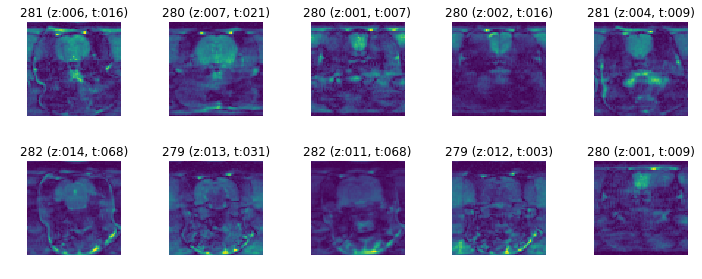

In [0]:
# this is just an example, you need the raw data to run this script.

images = []
for f in glob.iglob("/content/sample_data/bad/*"):
    images.append(np.asarray(Image.open(f)))
    
columns = 5
rows = round(len(images)/columns)

images = np.array(images)
fig, axs = plt.subplots(rows, columns, figsize=(10, rows*2))
fig.tight_layout()
axs = axs.ravel()

i = 0
print('Bad Images')
for count, filename in os.listdir('/content/sample_data/bad/'):
  RatName = filename[:-14] + " (" + "z:" + filename[10:-4] + ", t:" + filename[5:-9] + ")"
  axs[i].imshow(images[i])
  axs[i].set_title(RatName)
  axs[i].axis('off')
  i += 1

And here's a sample of what was labelled as 'good'.

Good Images


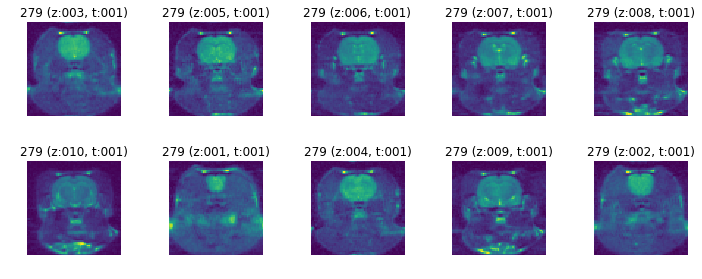

In [0]:
# this is just an example, you need the raw data to run this script.

images = []
for f in glob.iglob("/content/sample_data/good/*"):
    images.append(np.asarray(Image.open(f)))
    
columns = 5
rows = round(len(images)/columns)

images = np.array(images)
fig, axs = plt.subplots(rows, columns, figsize=(10, rows*2))
fig.tight_layout()
axs = axs.ravel()

i = 0
print('Good Images')
for filename in os.listdir('/content/sample_data/good/'):
  RatName = filename[:-14] + " (" + "z:" + filename[10:-4] + ", t:" + filename[5:-9] + ")"
  axs[i].imshow(images[i])
  axs[i].set_title(RatName)
  axs[i].axis('off')
  i += 1

### Objectives
CLARA aims to provide rodent fMRI pre-clinical studies with a pipeline for automatically detecting signal dropout in the form of dark slices. Through this approach, overall consistency of image quality may improve translational validity for researchers.

![alt text](https://i.imgur.com/lGOTyCL.png)

(*The virtuous cycle of preclinical imaging in human and rodent MRI*)

# 2. Building the Model

![alt text](https://i.imgur.com/tAyfB72.png)


The model (RatNet) is built using Keras, utilizing TensorFlow as the backend. TensorFlow was chosen as the backend due to better performance over Theano, and the ability to visualize the neural network using TensorBoard.

For predicting two categories (good/bad), our model utilizes three convolutional layers, each having a depth of 32. A Max Pooling layer is applied after all three convolutional layers with size (2,2).

After pooling, the data is fed through a single fully connected layer of size 128, and finally to the output layer, consisting of 2 softmax nodes.

## 2.1 Training the Model

Then we load the training dataset

In [0]:
def load_train(train_path, image_size, classes):
    images = []
    labels = []
    img_names = []
    cls = []

    print('Going to read training images')
    for fields in classes:   
        index = classes.index(fields)
        print('Now going to read {} files (Index: {})'.format(fields, index))
        path = os.path.join(train_path, fields, '*g')
        files = glob.glob(path)
        for fl in files:
            image = cv2.imread(fl)
            image = cv2.resize(image, (image_size, image_size),0,0, cv2.INTER_LINEAR)
            image = image.astype(np.float32)
            image = np.multiply(image, 1.0 / 255.0)
            images.append(image)
            label = np.zeros(len(classes))
            label[index] = 1.0
            labels.append(label)
            flbase = os.path.basename(fl)
            img_names.append(flbase)
            cls.append(fields)
    images = np.array(images)
    labels = np.array(labels)
    img_names = np.array(img_names)
    cls = np.array(cls)

    return images, labels, img_names, cls


class DataSet(object):

  def __init__(self, images, labels, img_names, cls):
    self._num_examples = images.shape[0]

    self._images = images
    self._labels = labels
    self._img_names = img_names
    self._cls = cls
    self._epochs_done = 0
    self._index_in_epoch = 0

  @property
  def images(self):
    return self._images

  @property
  def labels(self):
    return self._labels

  @property
  def img_names(self):
    return self._img_names

  @property
  def cls(self):
    return self._cls

  @property
  def num_examples(self):
    return self._num_examples

  @property
  def epochs_done(self):
    return self._epochs_done

  def next_batch(self, batch_size):
    """Return the next `batch_size` examples from this data set."""
    start = self._index_in_epoch
    self._index_in_epoch += batch_size

    if self._index_in_epoch > self._num_examples:
      # After each epoch we update this
      self._epochs_done += 1
      start = 0
      self._index_in_epoch = batch_size
      assert batch_size <= self._num_examples
    end = self._index_in_epoch

    return self._images[start:end], self._labels[start:end], self._img_names[start:end], self._cls[start:end]


def read_train_sets(train_path, image_size, classes, validation_size):
  class DataSets(object):
    pass
  data_sets = DataSets()

  images, labels, img_names, cls = load_train(train_path, image_size, classes)
  images, labels, img_names, cls = shuffle(images, labels, img_names, cls)  

  if isinstance(validation_size, float):
    validation_size = int(validation_size * images.shape[0])

  validation_images = images[:validation_size]
  validation_labels = labels[:validation_size]
  validation_img_names = img_names[:validation_size]
  validation_cls = cls[:validation_size]

  train_images = images[validation_size:]
  train_labels = labels[validation_size:]
  train_img_names = img_names[validation_size:]
  train_cls = cls[validation_size:]

  data_sets.train = DataSet(train_images, train_labels, train_img_names, train_cls)
  data_sets.valid = DataSet(validation_images, validation_labels, validation_img_names, validation_cls)

  return data_sets

In [0]:
#Adding Seed so that random initialization is consistent

seed(1)
set_random_seed(2)

batch_size = 32

#Prepare input data
classes = os.listdir('/content/training_data/')
num_classes = len(classes)

# 20% of the data will automatically be used for validation
validation_size = 0.2
img_size = 64
num_channels = 3
train_path='/content/training_data/'

# We shall load all the training and validation images and labels into memory using openCV and use that during training
data = dataset.read_train_sets(train_path, img_size, classes, validation_size=validation_size)


print("Complete reading input data. Will Now print a snippet of it")
print("Number of files in Training-set:\t\t{}".format(len(data.train.labels)))
print("Number of files in Validation-set:\t{}".format(len(data.valid.labels)))



session = tf.Session()
x = tf.placeholder(tf.float32, shape=[None, img_size,img_size,num_channels], name='x')

## labels
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)



##Network graph params
filter_size_conv1 = 3 
num_filters_conv1 = 32

filter_size_conv2 = 3
num_filters_conv2 = 32

filter_size_conv3 = 3
num_filters_conv3 = 64
    
fc_layer_size = 128

def create_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def create_biases(size):
    return tf.Variable(tf.constant(0.05, shape=[size]))



def create_convolutional_layer(input,
               num_input_channels, 
               conv_filter_size,        
               num_filters):  
    
    ## We shall define the weights that will be trained using create_weights function.
    weights = create_weights(shape=[conv_filter_size, conv_filter_size, num_input_channels, num_filters])
    ## We create biases using the create_biases function. These are also trained.
    biases = create_biases(num_filters)

    ## Creating the convolutional layer
    layer = tf.nn.conv2d(input=input,
                     filter=weights,
                     strides=[1, 1, 1, 1],
                     padding='SAME')

    layer += biases

    ## We shall be using max-pooling.  
    layer = tf.nn.max_pool(value=layer,
                            ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1],
                            padding='SAME')
    ## Output of pooling is fed to Relu which is the activation function for us.
    layer = tf.nn.relu(layer)

    return layer

    

def create_flatten_layer(layer):
    #We know that the shape of the layer will be [batch_size img_size img_size num_channels] 
    # But let's get it from the previous layer.
    layer_shape = layer.get_shape()

    ## Number of features will be img_height * img_width* num_channels. But we shall calculate it in place of hard-coding it.
    num_features = layer_shape[1:4].num_elements()

    ## Now, we Flatten the layer so we shall have to reshape to num_features
    layer = tf.reshape(layer, [-1, num_features])

    return layer


def create_fc_layer(input,          
             num_inputs,    
             num_outputs,
             use_relu=True):
    
    #Let's define trainable weights and biases.
    weights = create_weights(shape=[num_inputs, num_outputs])
    biases = create_biases(num_outputs)

    # Fully connected layer takes input x and produces wx+b.Since, these are matrices, we use matmul function in Tensorflow
    layer = tf.matmul(input, weights) + biases
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer


layer_conv1 = create_convolutional_layer(input=x,
               num_input_channels=num_channels,
               conv_filter_size=filter_size_conv1,
               num_filters=num_filters_conv1)
layer_conv2 = create_convolutional_layer(input=layer_conv1,
               num_input_channels=num_filters_conv1,
               conv_filter_size=filter_size_conv2,
               num_filters=num_filters_conv2)

layer_conv3= create_convolutional_layer(input=layer_conv2,
               num_input_channels=num_filters_conv2,
               conv_filter_size=filter_size_conv3,
               num_filters=num_filters_conv3)
          
layer_flat = create_flatten_layer(layer_conv3)

layer_fc1 = create_fc_layer(input=layer_flat,
                     num_inputs=layer_flat.get_shape()[1:4].num_elements(),
                     num_outputs=fc_layer_size,
                     use_relu=True)

layer_fc2 = create_fc_layer(input=layer_fc1,
                     num_inputs=fc_layer_size,
                     num_outputs=num_classes,
                     use_relu=False) 

y_pred = tf.nn.softmax(layer_fc2,name='y_pred')

y_pred_cls = tf.argmax(y_pred, dimension=1)
session.run(tf.global_variables_initializer())
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                    labels=y_true)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


session.run(tf.global_variables_initializer()) 


def show_progress(epoch, feed_dict_train, feed_dict_validate, val_loss):
    acc = session.run(accuracy, feed_dict=feed_dict_train)
    val_acc = session.run(accuracy, feed_dict=feed_dict_validate)
    msg = "Training Epoch {0} --- Training Accuracy: {1:>6.1%}, Validation Accuracy: {2:>6.1%},  Validation Loss: {3:.3f}"
    print(msg.format(epoch + 1, acc, val_acc, val_loss))

total_iterations = 0
saver = tf.train.Saver()
def train(num_iteration):
    global total_iterations
    
    for i in range(total_iterations,
                   total_iterations + num_iteration):

        x_batch, y_true_batch, _, cls_batch = data.train.next_batch(batch_size)
        x_valid_batch, y_valid_batch, _, valid_cls_batch = data.valid.next_batch(batch_size)

        
        feed_dict_tr = {x: x_batch,
                           y_true: y_true_batch}
        feed_dict_val = {x: x_valid_batch,
                              y_true: y_valid_batch}

        session.run(optimizer, feed_dict=feed_dict_tr)

        if i % int(data.train.num_examples/batch_size) == 0: 
            val_loss = session.run(cost, feed_dict=feed_dict_val)
            epoch = int(i / int(data.train.num_examples/batch_size))    
            
            show_progress(epoch, feed_dict_tr, feed_dict_val, val_loss)
            saver.save(session, 'RATNet-model')


    total_iterations += num_iteration

train(num_iteration=3000)

Going to read training images
Now going to read good files (Index: 0)
Now going to read bad files (Index: 1)
Complete reading input data. Will Now print a snippet of it
Number of files in Training-set:		22161
Number of files in Validation-set:	5540
Instructions for updating:
Use the `axis` argument instead
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Training Epoch 1 --- Training Accuracy:  96.9%, Validation Accuracy:  93.8%,  Validation Loss: 0.639
Training Epoch 2 --- Training Accuracy:  96.9%, Validation Accuracy: 100.0%,  Validation Loss: 0.004
Training Epoch 3 --- Training Accuracy: 100.0%, Validation Accuracy: 100.0%,  Validation Loss: 0.002
Training Epoch 4 --- Training Accuracy: 100.0%, Validation Accuracy: 100.0%,  Validation Loss: 0.001
Training Epoch 5 --- Trai

## 2.2 Validating The Model

Purely for visual inspection, we should take a look at the images labelled 'bad' in our test data folder. 

Now let's test our model to see if it gets it correct.

Do you want to test good images or bad images? BAD


INFO:tensorflow:Restoring parameters from ./RATNet-model


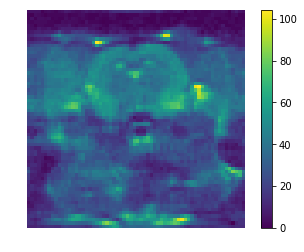

[[1. 0.]]
279 (z:008, t:032): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


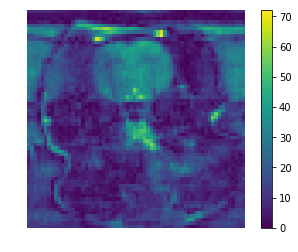

[[1. 0.]]
281 (z:006, t:016): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


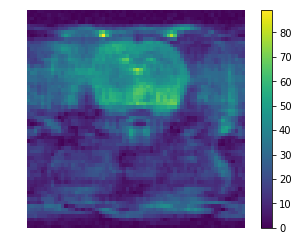

[[1. 0.]]
280 (z:008, t:001): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


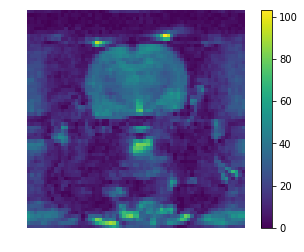

[[1. 0.]]
279 (z:009, t:028): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


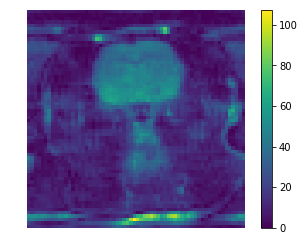

[[1. 0.]]
282 (z:005, t:028): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


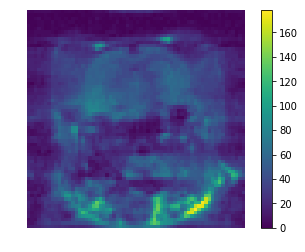

[[1. 0.]]
279 (z:012, t:030): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


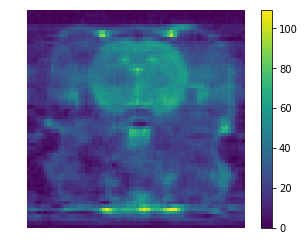

[[1. 0.]]
280 (z:008, t:011): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


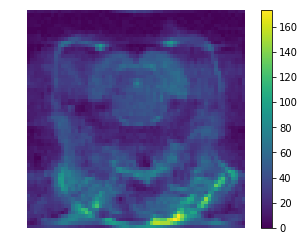

[[1. 0.]]
279 (z:014, t:002): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


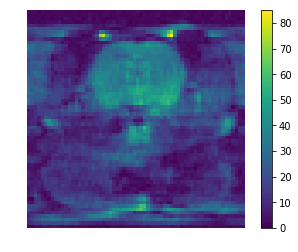

[[1. 0.]]
280 (z:007, t:021): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


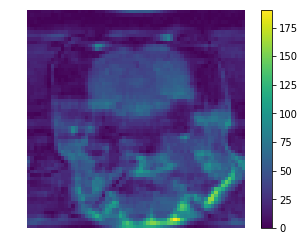

[[1. 0.]]
282 (z:012, t:068): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


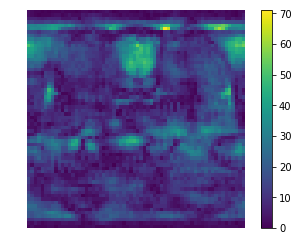

[[1. 0.]]
280 (z:001, t:007): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


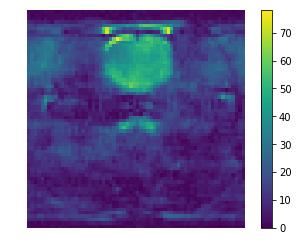

[[1. 0.]]
280 (z:003, t:016): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


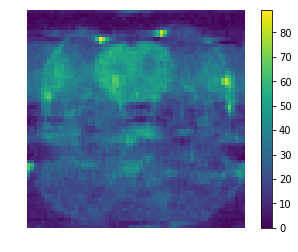

[[1. 0.]]
279 (z:004, t:065): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


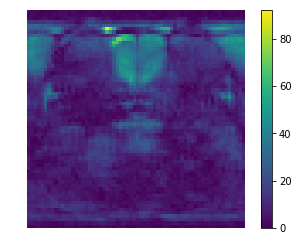

[[1. 0.]]
280 (z:002, t:016): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


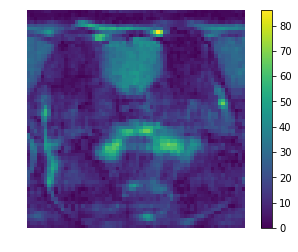

[[1. 0.]]
281 (z:004, t:009): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


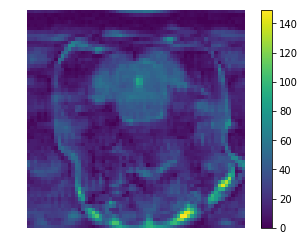

[[1. 0.]]
282 (z:014, t:068): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


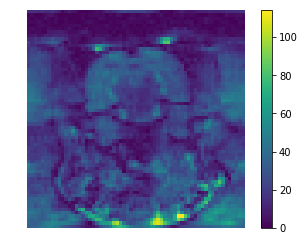

[[1. 0.]]
279 (z:013, t:031): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


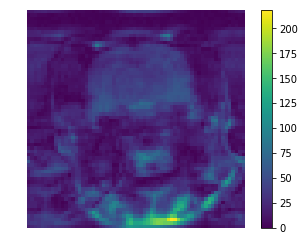

[[1. 0.]]
282 (z:011, t:068): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


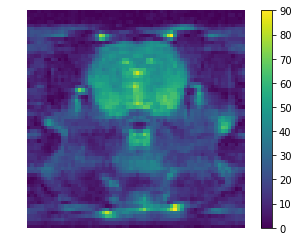

[[1. 0.]]
280 (z:008, t:021): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


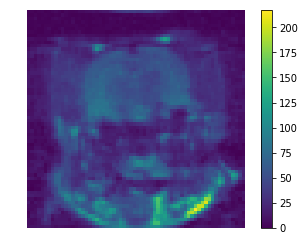

[[1. 0.]]
279 (z:012, t:069): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


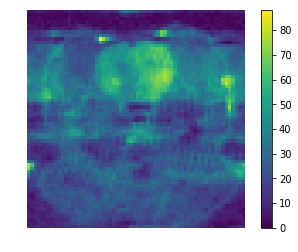

[[1. 0.]]
279 (z:004, t:033): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


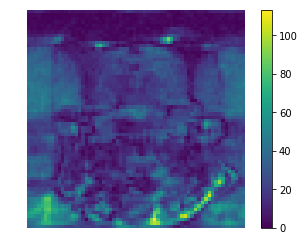

[[3.6630433e-37 1.0000000e+00]]
279 (z:012, t:003): bad
INFO:tensorflow:Restoring parameters from ./RATNet-model


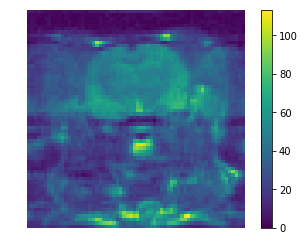

[[1. 0.]]
279 (z:009, t:031): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


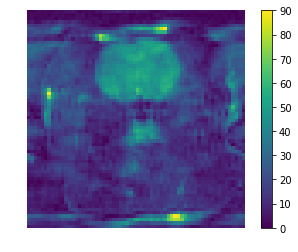

[[1. 0.]]
282 (z:004, t:028): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


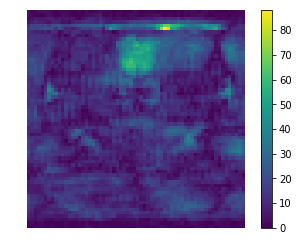

[[1. 0.]]
280 (z:001, t:009): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


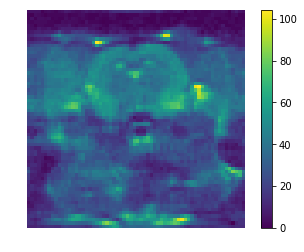

[[1. 0.]]
279 (z:008, t:032): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


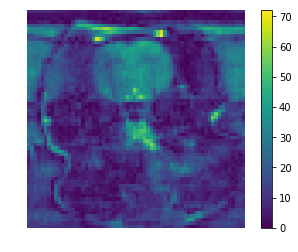

[[1. 0.]]
281 (z:006, t:016): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


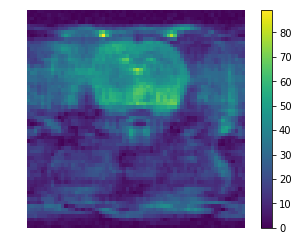

[[1. 0.]]
280 (z:008, t:001): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


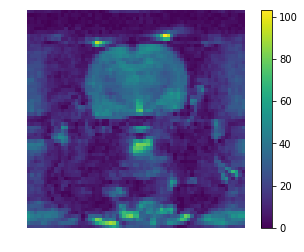

[[1. 0.]]
279 (z:009, t:028): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


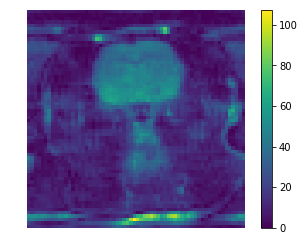

[[1. 0.]]
282 (z:005, t:028): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


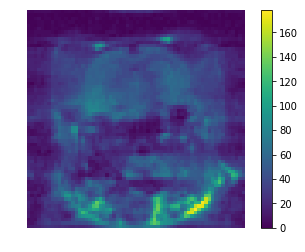

[[1. 0.]]
279 (z:012, t:030): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


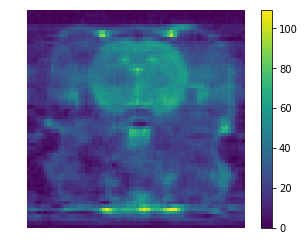

[[1. 0.]]
280 (z:008, t:011): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


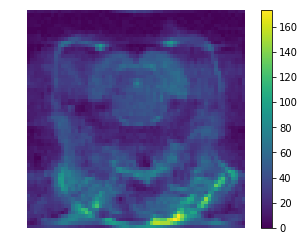

[[1. 0.]]
279 (z:014, t:002): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


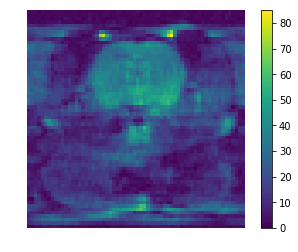

[[1. 0.]]
280 (z:007, t:021): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


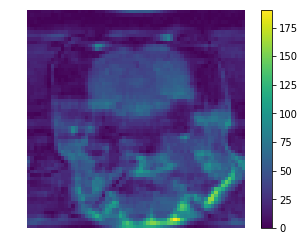

[[1. 0.]]
282 (z:012, t:068): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


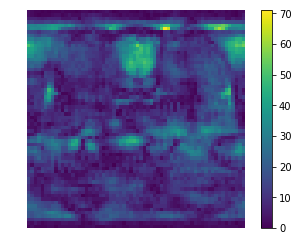

[[1. 0.]]
280 (z:001, t:007): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


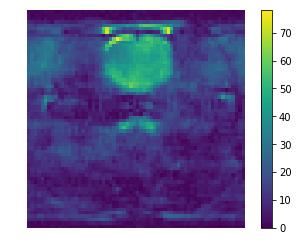

[[1. 0.]]
280 (z:003, t:016): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


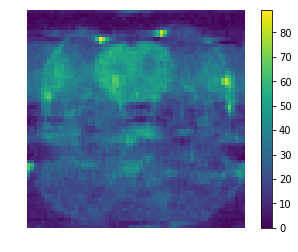

[[1. 0.]]
279 (z:004, t:065): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


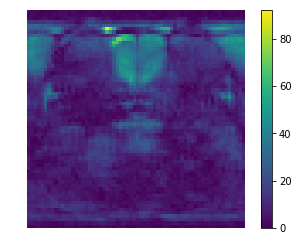

[[1. 0.]]
280 (z:002, t:016): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


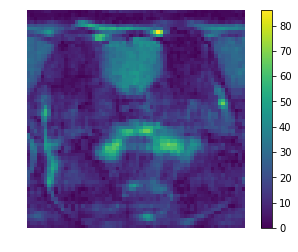

[[1. 0.]]
281 (z:004, t:009): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


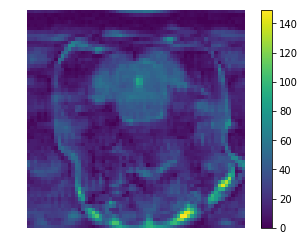

[[1. 0.]]
282 (z:014, t:068): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


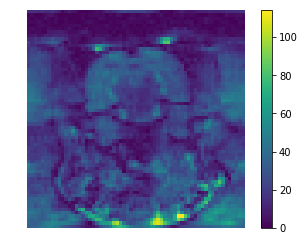

[[1. 0.]]
279 (z:013, t:031): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


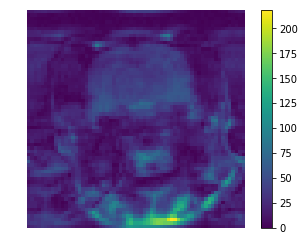

[[1. 0.]]
282 (z:011, t:068): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


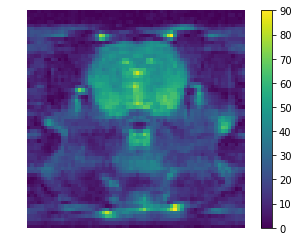

[[1. 0.]]
280 (z:008, t:021): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


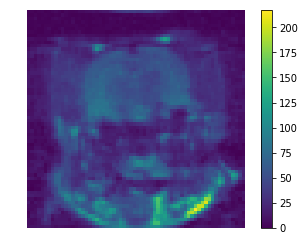

[[1. 0.]]
279 (z:012, t:069): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


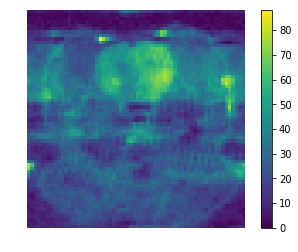

[[1. 0.]]
279 (z:004, t:033): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


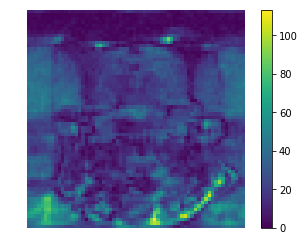

[[3.6630433e-37 1.0000000e+00]]
279 (z:012, t:003): bad
INFO:tensorflow:Restoring parameters from ./RATNet-model


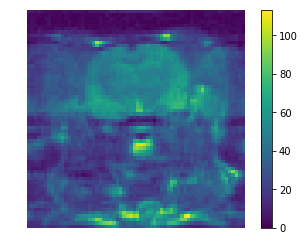

[[1. 0.]]
279 (z:009, t:031): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


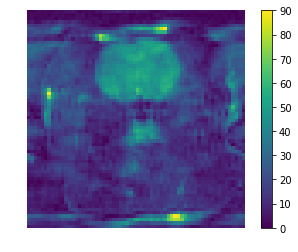

[[1. 0.]]
282 (z:004, t:028): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


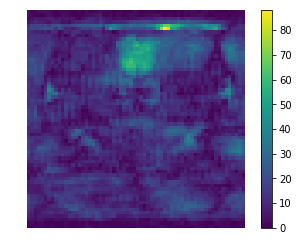

[[1. 0.]]
280 (z:001, t:009): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


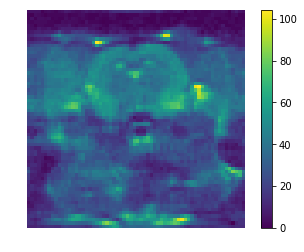

[[1. 0.]]
279 (z:008, t:032): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


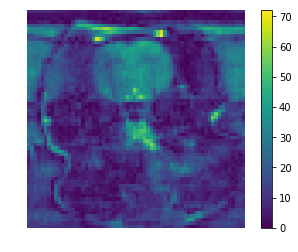

[[1. 0.]]
281 (z:006, t:016): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


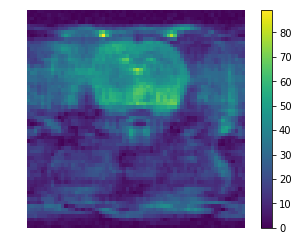

[[1. 0.]]
280 (z:008, t:001): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


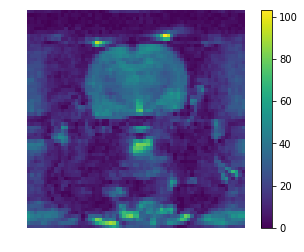

[[1. 0.]]
279 (z:009, t:028): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


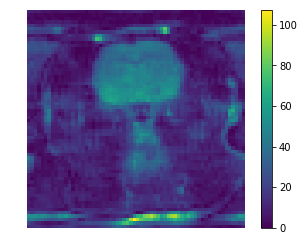

[[1. 0.]]
282 (z:005, t:028): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


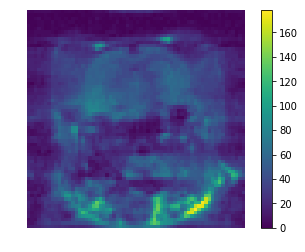

[[1. 0.]]
279 (z:012, t:030): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


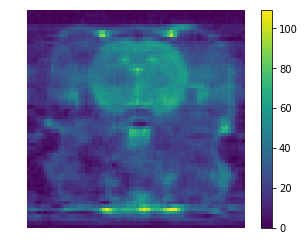

[[1. 0.]]
280 (z:008, t:011): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


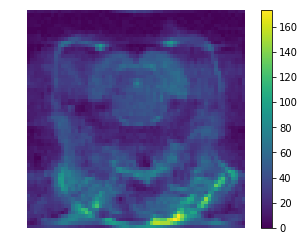

[[1. 0.]]
279 (z:014, t:002): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


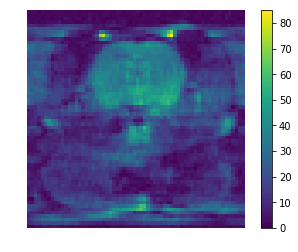

[[1. 0.]]
280 (z:007, t:021): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


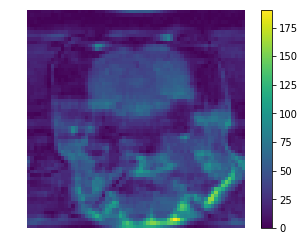

[[1. 0.]]
282 (z:012, t:068): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


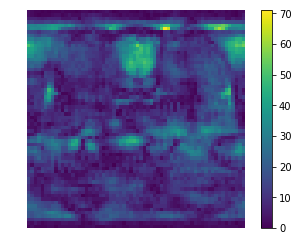

[[1. 0.]]
280 (z:001, t:007): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


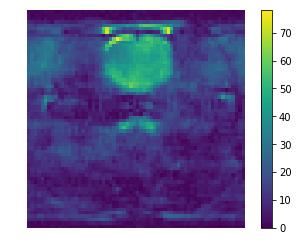

[[1. 0.]]
280 (z:003, t:016): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


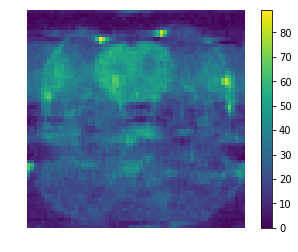

[[1. 0.]]
279 (z:004, t:065): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


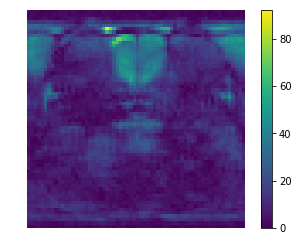

[[1. 0.]]
280 (z:002, t:016): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


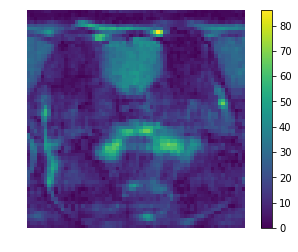

[[1. 0.]]
281 (z:004, t:009): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


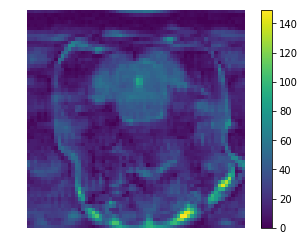

[[1. 0.]]
282 (z:014, t:068): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


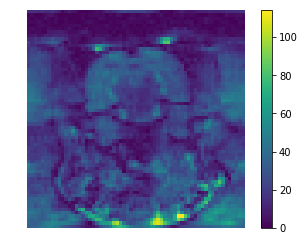

[[1. 0.]]
279 (z:013, t:031): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


Exception ignored in: <bound method BaseSession.__del__ of <tensorflow.python.client.session.Session object at 0x7f2554732a58>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 733, in __del__
    self.close()
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 728, in close
    tf_session.TF_CloseSession(self._session)
KeyboardInterrupt: 


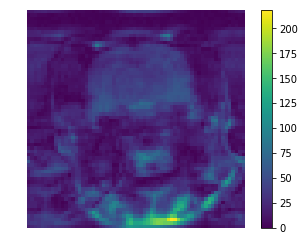

[[1. 0.]]
282 (z:011, t:068): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


KeyboardInterrupt: ignored

In [0]:
def test():
  ask_cat = input("Do you want to test good images or bad images? ")

  bad_path = '/content/testing_data/bad/'
  good_path = '/content/testing_data/good/'

  if ask_cat.lower() == 'bad':

    for file in os.listdir(bad_path):
      image_size=64
      num_channels=3
      images = []

      # Reading the image using OpenCV
      image = cv2.imread(os.path.join(bad_path,file))

      # Resizing the image to our desired size and preprocessing will be done exactly as done during training
      #image = cv2.resize(image, (image_size, image_size),0,0, cv2.INTER_LINEAR)
      images.append(image)
      images = np.array(images, dtype=np.uint8)
      images = images.astype('float32')
      #images = np.multiply(images, 1.0/255.0)

      #The input to the network is of shape [None image_size image_size num_channels]. Hence we reshape.
      x_batch = images.reshape(1, image_size,image_size,num_channels)

      ## Let us restore the saved model 
      sess = tf.Session()
      # Step-1: Recreate the network graph. At this step only graph is created.
      saver = tf.train.import_meta_graph('RATNet-model.meta')
      # Step-2: Now let's load the weights saved using the restore method.
      saver.restore(sess, tf.train.latest_checkpoint('./'))

      # Accessing the default graph which we have restored
      graph = tf.get_default_graph()

      # Now, let's get hold of the op that we can be processed to get the output.
      # In the original network y_pred is the tensor that is the prediction of the network
      y_pred = graph.get_tensor_by_name("y_pred:0")

      ## Let's feed the images to the input placeholders
      x= graph.get_tensor_by_name("x:0") 
      y_true = graph.get_tensor_by_name("y_true:0") 
      y_test_images = np.zeros((1, len(os.listdir('training_data')))) 


      ### Creating the feed_dict that is required to be fed to calculate y_pred 
      feed_dict_testing = {x: x_batch, y_true: y_test_images}
      result=sess.run(y_pred, feed_dict=feed_dict_testing)

      #plot image
      %matplotlib inline
      pil_im = Image.open(os.path.join(bad_path,file), 'r')
      imshow(np.asarray(pil_im))
      plt.colorbar()
      plt.axis('off')
      plt.show()

      # result is of this format [probabiliy_of_rose probability_of_sunflower]
      res_label = ['good','bad']
      print(result)
      print("{} (z:{}, t:{}): ".format(file[:-14],file[10:-4],file[5:-9]) + res_label[result.argmax()])

  elif ask_cat.lower() == "good":
    for file in os.listdir(good_path):
      image_size=64
      num_channels=3
      images = []

      # Reading the image using OpenCV
      image = cv2.imread(os.path.join(good_path,file))

      # Resizing the image to our desired size and preprocessing will be done exactly as done during training
      #image = cv2.resize(image, (image_size, image_size),0,0, cv2.INTER_LINEAR)
      images.append(image)
      images = np.array(images, dtype=np.uint8)
      images = images.astype('float32')
      #images = np.multiply(images, 1.0/255.0)

      #The input to the network is of shape [None image_size image_size num_channels]. Hence we reshape.
      x_batch = images.reshape(1, image_size,image_size,num_channels)

      ## Let us restore the saved model 
      sess = tf.Session()
      # Step-1: Recreate the network graph. At this step only graph is created.
      saver = tf.train.import_meta_graph('RATNet-model.meta')
      # Step-2: Now let's load the weights saved using the restore method.
      saver.restore(sess, tf.train.latest_checkpoint('./'))

      # Accessing the default graph which we have restored
      graph = tf.get_default_graph()

      # Now, let's get hold of the op that we can be processed to get the output.
      # In the original network y_pred is the tensor that is the prediction of the network
      y_pred = graph.get_tensor_by_name("y_pred:0")

      ## Let's feed the images to the input placeholders
      x= graph.get_tensor_by_name("x:0") 
      y_true = graph.get_tensor_by_name("y_true:0") 
      y_test_images = np.zeros((1, len(os.listdir('training_data')))) 


      ### Creating the feed_dict that is required to be fed to calculate y_pred 
      feed_dict_testing = {x: x_batch, y_true: y_test_images}
      result=sess.run(y_pred, feed_dict=feed_dict_testing)

      # result is of this format [probabiliy_of_rose probability_of_sunflower]
      res_label = ['good','bad']
      print(result)
      print("{} (z:{}, t:{}): ".format(file[:-14],file[10:-4],file[5:-9]) + res_label[result.argmax()])
  else:
    print("Sorry, I didn't understand that. Let's try again...")
    test()
    
test()

# 3. Try It Out!

## 3.1 Input File

Select a single 4D NIfTI (.nii) rat image.

In [0]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{upload_name}" with length {length} bytes'.format(
      upload_name=fn, length=len(uploaded[fn])))
  
  # set fn as your 4d nifti file
  image_array = nibabel.load(fn).get_data()
  # set 4d array dimension values
  nx, ny, nz, nw = image_array.shape
  # set destination folder
  dst = "/content/png_" + fn[:-4]
  if not os.path.exists(dst):
          os.makedirs(dst)
          print("Created ouput directory: " + dst)
        
  print("Converting NIfTI to png...")
  
  volumes = image_array.shape[3]
  slices = image_array.shape[2]

  volume_counter = 0
  image_counter = 0

  # iterate through volumes
  for j in range(0, volumes):
    slice_counter = 0
    # iterate through slices
    for i in range(0, slices):
      # set nifti as a numpy array
      data = numpy.rot90(image_array[:, :, i, j])
      #alternate slices and save as png
      if (slice_counter % 1) == 0:
        image_name = fn[:-4] + "_t" "{:0>3}".format(str(j)) + "_z" + "{:0>3}".format(str(i))+ ".png"
        scipy.misc.imsave(image_name, data)
        #move images to folder
        src = "/content/" + image_name
        shutil.move(src, dst)
        slice_counter += 1
        image_counter += 1
    volume_counter += 1
    
  print("Finished converting images") 

## 3.2 Predict Noise

Which volume should we run the prediction on? 18
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./RATNet-model


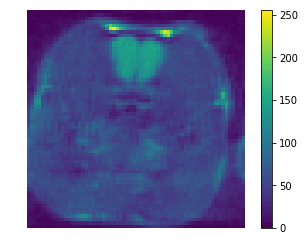

[[1. 0.]]
282 (t:18, z:0): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


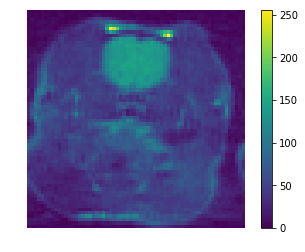

[[1. 0.]]
282 (t:18, z:1): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


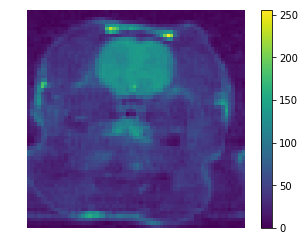

[[1. 0.]]
282 (t:18, z:2): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


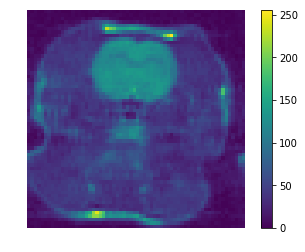

[[1. 0.]]
282 (t:18, z:3): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


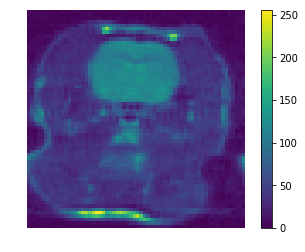

[[1. 0.]]
282 (t:18, z:4): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


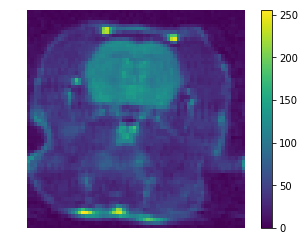

[[1. 0.]]
282 (t:18, z:5): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


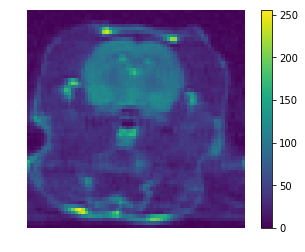

[[1. 0.]]
282 (t:18, z:6): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


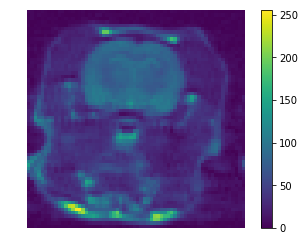

[[1. 0.]]
282 (t:18, z:7): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


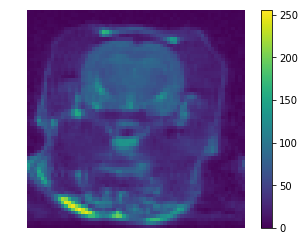

[[1. 0.]]
282 (t:18, z:8): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


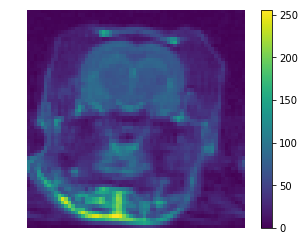

[[1. 0.]]
282 (t:18, z:9): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


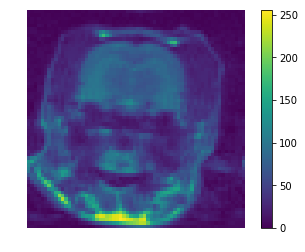

[[1. 0.]]
282 (t:18, z:10): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


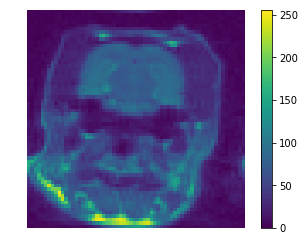

[[1. 0.]]
282 (t:18, z:11): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


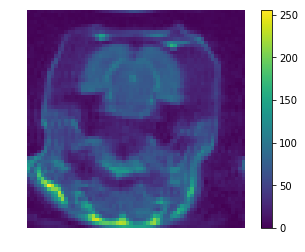

[[1. 0.]]
282 (t:18, z:12): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


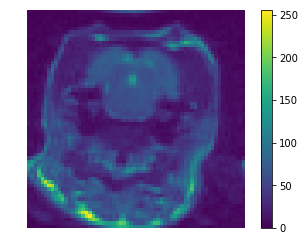

[[1. 0.]]
282 (t:18, z:13): good
INFO:tensorflow:Restoring parameters from ./RATNet-model


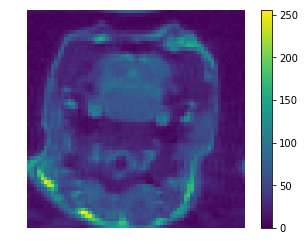

[[1. 0.]]
282 (t:18, z:14): good


In [0]:
ask_vol = int(input("Which volume should we run the prediction on? "))

# if user asked for vol 1, set to first vol
if ask_vol == 1:
  ask_vol = ask_vol - 1

x = ask_vol * 15
y = x + 15

slice_counter = 0
for i in range(x, y):
  # First, pass the path of the image
  filename = dst + "/" + fn[:-4] + "_t" "{:0>3}".format(str(ask_vol)) + "_z" + "{:0>3}".format(str(slice_counter))+ ".png"
  image_size=64
  num_channels=3
  images = []

  # Reading the image using OpenCV
  image = cv2.imread(filename)

  # Resizing the image to our desired size and preprocessing will be done exactly as done during training
  image = cv2.resize(image, (image_size, image_size),0,0, cv2.INTER_LINEAR)
  images.append(image)
  images = np.array(images, dtype=np.uint8)
  images = images.astype('float32')
  #images = np.multiply(images, 1.0/255.0)

  #The input to the network is of shape [None image_size image_size num_channels]. Hence we reshape.
  x_batch = images.reshape(1, image_size,image_size,num_channels)

  ## Let us restore the saved model 
  sess = tf.Session()
  # Step-1: Recreate the network graph. At this step only graph is created.
  saverme = tf.train.import_meta_graph('RATNet-model.meta')
  # Step-2: Now let's load the weights saved using the restore method.
  saverme.restore(sess, tf.train.latest_checkpoint('./'))

  # Accessing the default graph which we have restored
  graph = tf.get_default_graph()

  # Now, let's get hold of the op that we can be processed to get the output.
  # In the original network y_pred is the tensor that is the prediction of the network
  y_pred = graph.get_tensor_by_name("y_pred:0")

  ## Let's feed the images to the input placeholders
  x= graph.get_tensor_by_name("x:0") 
  y_true = graph.get_tensor_by_name("y_true:0") 
  y_test_images = np.zeros((1, len(os.listdir('training_data')))) 


  ### Creating the feed_dict that is required to be fed to calculate y_pred 
  feed_dict_testing = {x: x_batch, y_true: y_test_images}
  result=sess.run(y_pred, feed_dict=feed_dict_testing)

  %matplotlib inline
  pil_im = Image.open(filename, 'r')
  imshow(np.asarray(pil_im))
  plt.colorbar()
  plt.axis('off')
  plt.show()

  # result is of this format [probabiliy_of_good probability_of_bad]
  res_label = ['good','bad']
  print(result)
  print(filename[-17:-14] + " (t:" + str(ask_vol) + ", z:" + str(slice_counter) + "): " + res_label[result.argmax()])  
  slice_counter += 1

# 5. Future Work

* 4D time-series fMRI data support. Currenly only supports 3D (or 4D-segmented data).
* Program the neural network to retrain with new photos. This is a common practice, and only serves to optimize the model. Checks would be put in place to validate the images before being added to the classifier, in order to prevent low quality images from altering the classifier too drastically.

* Port the Keras model to CoreML, and deploy to an RatNet iOS application. CoreML is a framework designed by Apple for adding machine learning to iOS devices. This allows the ability of Python developers to export their models, convert the file to a .mlmodel file, and add the file to the iOS development cycle.

# 6. Acknowledgement

For my initial research in which this tool is based on, I acknowledge the Royal Society (grant) and the Wellcome Trust (ISSF) for funding support, as well as Dr. Cyril Pernet, Dr. Gerry Thompson, Dr. Maurits Jansen, and Dr. Anjanette Harris of the University of Edinburgh for technical advice. I also extend my gratitude to our colleagues at the Laboratory of Magnetic Resonance Research (Chang-Gung University, Taiwan), Sun-Lin Han, Dr. Jiun-Jie Wang, and Dr. Chih-Chien Tsai for collaborative research exchange that helped to build the foundations for the 2nd part of my MSc thesis. Finally, I would like to thank my supervisor Dr. Szu-Han Wang at the Centre of Clinical Brain Sciences (CCBS) who's unwavering patience, perseverance, and knowledge has supported me throughout my project.

In order to build CLARA, I made use of Ankit Sachan's helpful TensorFlow [tutorials](https://cv-tricks.com/tensorflow-tutorial/training-convolutional-neural-network-for-image-classification/) and [scripts](https://github.com/sankit1/cv-tricks.com/tree/master/Tensorflow-tutorials/tutorial-2-image-classifier) for image classification. Furthermore, I also would like to extend my thanks to Siraj Raval for the inspiring deep learning in medical-imaging [guides](https://github.com/llSourcell/AI_in_Medicine_Clinical_Imaging_Classification#neural-network-architecture). 

Finally, I want to thank OpenCV and everyone at Google (especially at TensorFlow) for providing the tools to make all this possible. 

Happy Google IO 2019!